# TPS 12/21 - Comparison of Classifiers

In this notebook, we test out several scikit-learn compatible classifiers. For the most part, we do not do any model tuning and leave default settings.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Save data as .feather format
original = pd.read_feather('../data/original.feather')
train = pd.read_feather('../data/train.feather')

# Drop Label = 5
train = train[train.Cover_Type != 5]

In [4]:
# Split synthetic data
train, test = train_test_split(train, test_size = 1500000, random_state = RANDOM_SEED)
features = [x for x in train.columns if x not in ['Id','Cover_Type']]

gc.collect()

# Label Encoding
new_encoder = LabelEncoder()
train["Cover_Type"] = new_encoder.fit_transform(train["Cover_Type"])
test["Cover_Type"] = new_encoder.transform(test["Cover_Type"])

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

print(f'\nOriginal Train Size: {original.shape[0]} rows, {original.shape[1]} cols')
print(f'Synthetic Train Size: {train.shape[0]} rows, {train.shape[1]} cols')
print(f'Synthetic Test Size: {test.shape[0]} rows, {test.shape[1]} cols\n')


Original Train Size: 581012 rows, 55 cols
Synthetic Train Size: 2499999 rows, 56 cols
Synthetic Test Size: 1500000 rows, 56 cols



# Scoring Function

In [5]:
# Scoring/Training Baseline Function
def score_newdata(sklearn_model):
    
    print('Data: TPS 12/21 (Synthetic)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], len(train.Cover_Type.value_counts())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = train[features].iloc[train_idx]
        X_valid = train[features].iloc[valid_idx]
        X_test = test[features]
        
        # Training and Target Labels
        y_train = train['Cover_Type'].iloc[train_idx]
        y_valid = train['Cover_Type'].iloc[valid_idx]
        y_test = test['Cover_Type']
        
        gc.collect()
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    test_preds = np.argmax(test_preds, axis = 1)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('\nHoldout Accuracy:', accuracy_score(y_test, test_preds))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()


In [6]:
# Scoring/Training Baseline Function
def score_olddata(sklearn_model):
    
    print('Data: Forest Covtype (Original)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        
        # Training and Target Labels
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]
        
        gc.collect()
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()

# Logistic Regression

In [7]:
# Logistic Regression
logit_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(
        solver = 'saga',
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.91703 in 371.47s.
Fold 1 Accuracy: 0.91731 in 372.11s.
Fold 2 Accuracy: 0.9175 in 355.18s.
Fold 3 Accuracy: 0.91732 in 347.47s.
Fold 4 Accuracy: 0.91721 in 348.77s.

Average CV Accuracy: 0.91728
Worst CV Accuracy: 0.91703

Holdout Accuracy: 0.91687
Training Time: 1795.0s



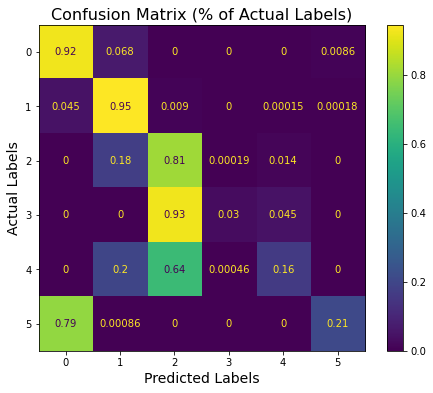

In [8]:
score_newdata(logit_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.72439 in 85.31s.
Fold 1 Accuracy:  0.72415 in 85.47s.
Fold 2 Accuracy:  0.72574 in 85.04s.
Fold 3 Accuracy:  0.72267 in 84.74s.
Fold 4 Accuracy:  0.72652 in 84.46s.

Average Accuracy: 0.72469
Worst Accuracy: 0.72267
Training Time: 425.01s



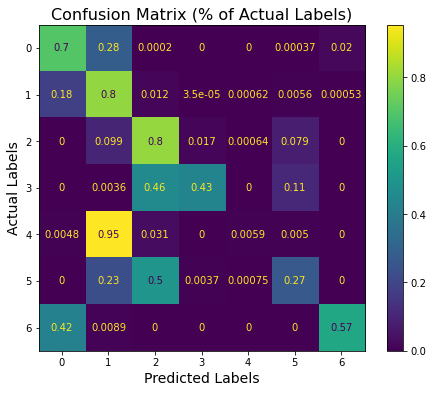

In [9]:
score_olddata(logit_pipeline)

# Ridge Regression

In [10]:
# Class extending Ridge Regression
class ExtendedRidgeClassifier(RidgeClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))
    
# Ridge Regression
ridge_pipeline = make_pipeline(
    RobustScaler(),
    ExtendedRidgeClassifier(
        solver = 'saga',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.89616 in 103.53s.
Fold 1 Accuracy: 0.89573 in 111.93s.
Fold 2 Accuracy: 0.89642 in 103.61s.
Fold 3 Accuracy: 0.8956 in 102.18s.
Fold 4 Accuracy: 0.89675 in 104.28s.

Average CV Accuracy: 0.89613
Worst CV Accuracy: 0.8956

Holdout Accuracy: 0.8963446666666667
Training Time: 525.53s



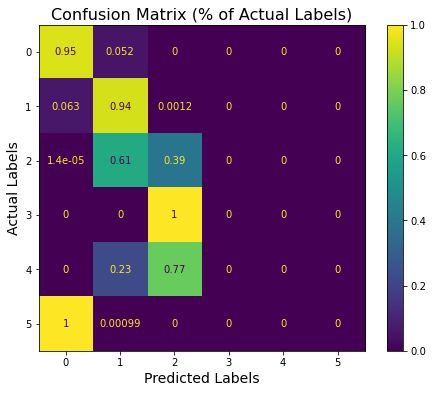

In [11]:
score_newdata(ridge_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.701 in 237.49s.
Fold 1 Accuracy:  0.70206 in 222.79s.
Fold 2 Accuracy:  0.70189 in 230.09s.
Fold 3 Accuracy:  0.69861 in 230.72s.
Fold 4 Accuracy:  0.70192 in 233.96s.

Average Accuracy: 0.7011
Worst Accuracy: 0.69861
Training Time: 1155.06s



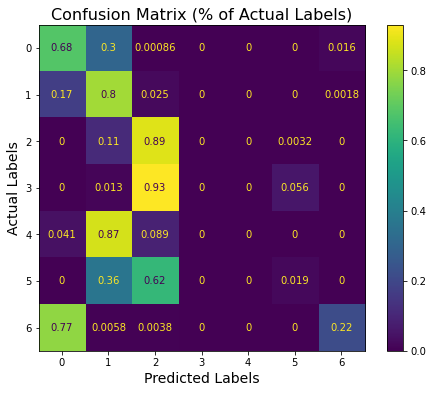

In [12]:
score_olddata(ridge_pipeline)

# Linear Discriminant Analysis

In [13]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    RobustScaler(),
    LinearDiscriminantAnalysis(),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.87794 in 17.9s.
Fold 1 Accuracy: 0.87856 in 17.41s.
Fold 2 Accuracy: 0.87838 in 17.45s.
Fold 3 Accuracy: 0.87824 in 17.54s.
Fold 4 Accuracy: 0.87873 in 17.26s.

Average CV Accuracy: 0.87837
Worst CV Accuracy: 0.87794

Holdout Accuracy: 0.8783026666666667
Training Time: 87.56s



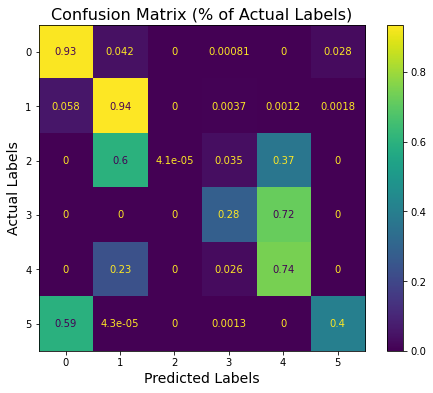

In [14]:
score_newdata(lda_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.67946 in 3.63s.
Fold 1 Accuracy:  0.67941 in 3.62s.
Fold 2 Accuracy:  0.67995 in 3.6s.
Fold 3 Accuracy:  0.67655 in 3.58s.
Fold 4 Accuracy:  0.68301 in 3.64s.

Average Accuracy: 0.67967
Worst Accuracy: 0.67655
Training Time: 18.05s



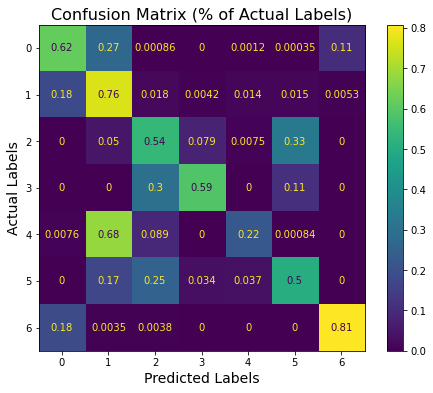

In [15]:
score_olddata(lda_pipeline)

# SGDClassifier

In [16]:
# Extended SGDClassifier
class ExtendedSGDClassifier(SGDClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))

# SGDClassifier
sgd_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedSGDClassifier(
        learning_rate = 'optimal', 
        penalty = 'l2', 
        random_state = RANDOM_SEED
    )
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.90144 in 21.56s.
Fold 1 Accuracy: 0.90079 in 21.7s.
Fold 2 Accuracy: 0.90092 in 21.53s.
Fold 3 Accuracy: 0.90066 in 21.73s.
Fold 4 Accuracy: 0.90218 in 21.64s.

Average CV Accuracy: 0.9012
Worst CV Accuracy: 0.90066

Holdout Accuracy: 0.9013426666666666
Training Time: 108.17s



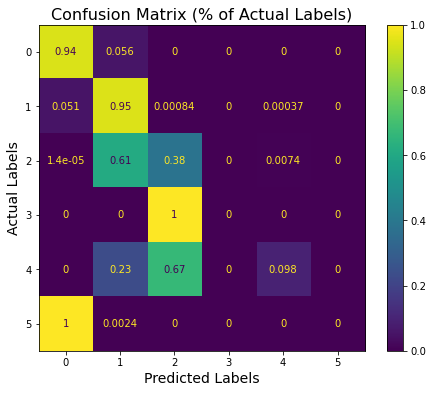

In [17]:
score_newdata(sgd_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.71334 in 6.23s.
Fold 1 Accuracy:  0.71397 in 6.06s.
Fold 2 Accuracy:  0.71368 in 6.11s.
Fold 3 Accuracy:  0.71119 in 6.35s.
Fold 4 Accuracy:  0.71232 in 6.51s.

Average Accuracy: 0.7129
Worst Accuracy: 0.71119
Training Time: 31.25s



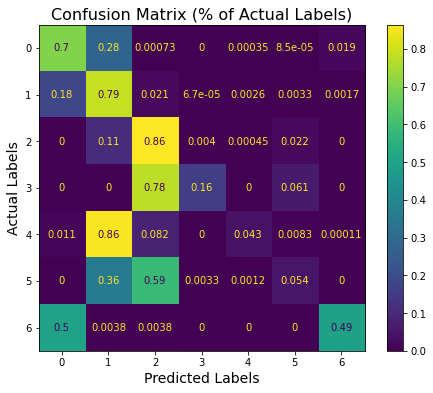

In [18]:
score_olddata(sgd_pipeline)

# Naive Bayes

In [19]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(),
    MultinomialNB(),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.59181 in 6.31s.
Fold 1 Accuracy: 0.59169 in 5.65s.
Fold 2 Accuracy: 0.59089 in 5.59s.
Fold 3 Accuracy: 0.59213 in 5.54s.
Fold 4 Accuracy: 0.59176 in 5.53s.

Average CV Accuracy: 0.59166
Worst CV Accuracy: 0.59089

Holdout Accuracy: 0.5914446666666666
Training Time: 28.62s



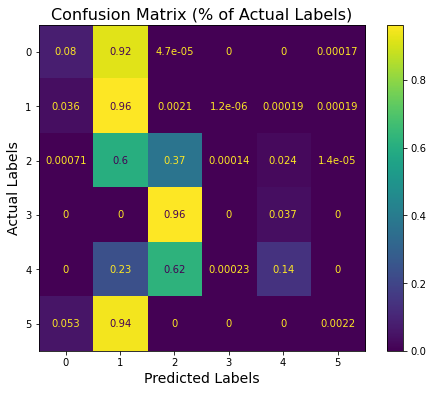

In [20]:
score_newdata(nb_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.64276 in 0.92s.
Fold 1 Accuracy:  0.64205 in 0.93s.
Fold 2 Accuracy:  0.64276 in 0.93s.
Fold 3 Accuracy:  0.64037 in 0.89s.
Fold 4 Accuracy:  0.64216 in 1.13s.

Average Accuracy: 0.64202
Worst Accuracy: 0.64037
Training Time: 4.8s



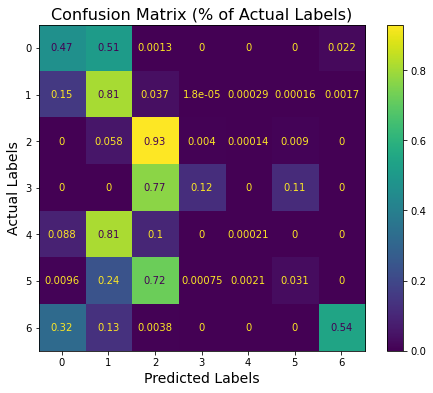

In [21]:
score_olddata(nb_pipeline)

# Multilayer Perceptron

In [22]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(
        hidden_layer_sizes=(len(features), len(features)//2),
        batch_size = 512, 
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95769 in 138.37s.
Fold 1 Accuracy: 0.95781 in 119.45s.
Fold 2 Accuracy: 0.95761 in 165.7s.
Fold 3 Accuracy: 0.95803 in 123.91s.
Fold 4 Accuracy: 0.95889 in 185.31s.

Average CV Accuracy: 0.958
Worst CV Accuracy: 0.95761

Holdout Accuracy: 0.9602486666666666
Training Time: 732.73s



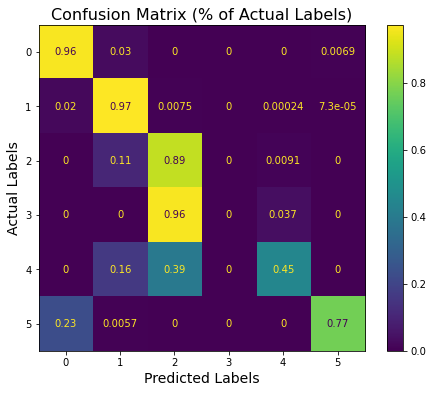

In [23]:
score_newdata(mlp_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.86104 in 72.43s.
Fold 1 Accuracy:  0.85977 in 86.17s.
Fold 2 Accuracy:  0.85056 in 46.01s.
Fold 3 Accuracy:  0.86471 in 111.02s.
Fold 4 Accuracy:  0.86188 in 92.69s.

Average Accuracy: 0.85959
Worst Accuracy: 0.85056
Training Time: 408.31s



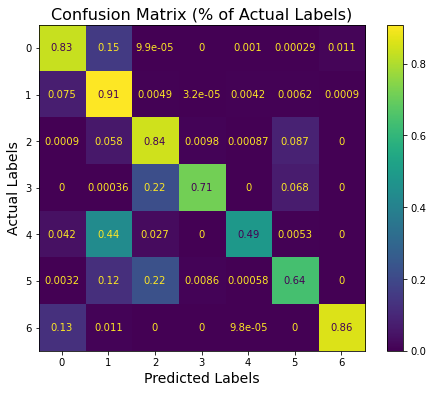

In [24]:
score_olddata(mlp_pipeline)

# XGBoost

In [25]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95874 in 66.14s.
Fold 1 Accuracy: 0.95873 in 65.1s.
Fold 2 Accuracy: 0.95876 in 64.98s.
Fold 3 Accuracy: 0.95925 in 65.65s.
Fold 4 Accuracy: 0.95872 in 65.18s.

Average CV Accuracy: 0.95884
Worst CV Accuracy: 0.95872

Holdout Accuracy: 0.9592026666666666
Training Time: 327.05s



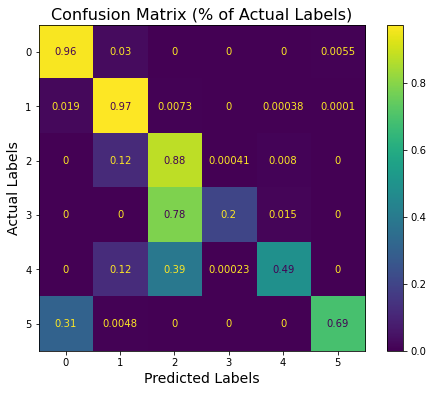

In [26]:
score_newdata(xgb_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.87115 in 12.98s.
Fold 1 Accuracy:  0.87006 in 12.98s.
Fold 2 Accuracy:  0.87063 in 12.92s.
Fold 3 Accuracy:  0.86945 in 13.02s.
Fold 4 Accuracy:  0.87145 in 13.39s.

Average Accuracy: 0.87055
Worst Accuracy: 0.86945
Training Time: 65.29s



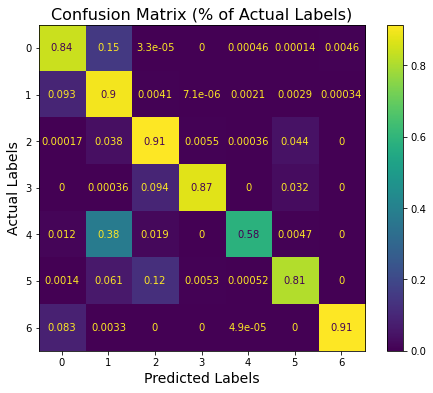

In [27]:
score_olddata(xgb_pipeline)

# LightGBM

In [28]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95355 in 40.13s.
Fold 1 Accuracy: 0.95398 in 37.6s.
Fold 2 Accuracy: 0.95112 in 38.68s.
Fold 3 Accuracy: 0.9512 in 37.37s.
Fold 4 Accuracy: 0.95536 in 35.64s.

Average CV Accuracy: 0.95304
Worst CV Accuracy: 0.95112

Holdout Accuracy: 0.9567446666666667
Training Time: 189.43s



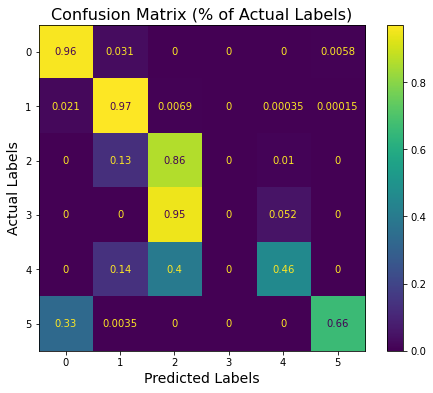

In [29]:
score_newdata(lgbm_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.85006 in 4.81s.
Fold 1 Accuracy:  0.85744 in 4.89s.
Fold 2 Accuracy:  0.85594 in 4.83s.
Fold 3 Accuracy:  0.85245 in 4.91s.
Fold 4 Accuracy:  0.85308 in 5.06s.

Average Accuracy: 0.85379
Worst Accuracy: 0.85006
Training Time: 24.51s



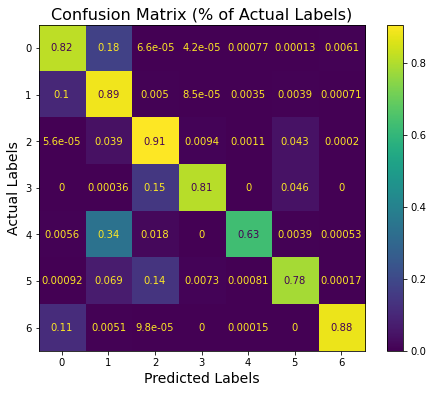

In [30]:
score_olddata(lgbm_pipeline)

# CatBoost

In [31]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        boosting_type = 'Plain',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95907 in 634.11s.
Fold 1 Accuracy: 0.95945 in 631.69s.
Fold 2 Accuracy: 0.95932 in 630.35s.
Fold 3 Accuracy: 0.95969 in 630.5s.
Fold 4 Accuracy: 0.95926 in 631.13s.

Average CV Accuracy: 0.95936
Worst CV Accuracy: 0.95907

Holdout Accuracy: 0.9596766666666666
Training Time: 3157.78s



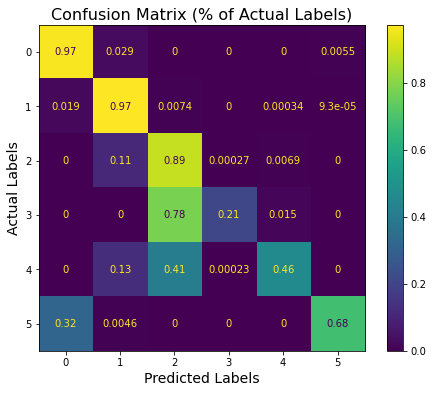

In [32]:
score_newdata(catboost_pipeline)

Data: Forest Covtype (Original)

Fold 0 Accuracy:  0.88428 in 144.83s.
Fold 1 Accuracy:  0.88424 in 143.76s.
Fold 2 Accuracy:  0.88668 in 143.15s.
Fold 3 Accuracy:  0.884 in 144.55s.
Fold 4 Accuracy:  0.887 in 146.43s.

Average Accuracy: 0.88524
Worst Accuracy: 0.884
Training Time: 722.72s



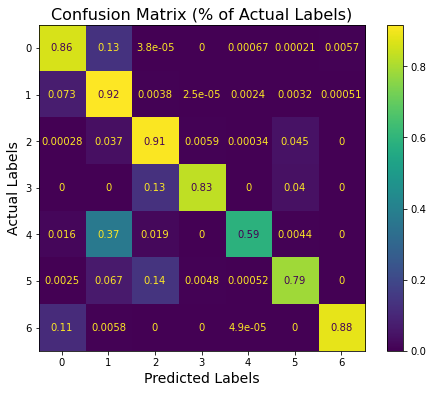

In [33]:
score_olddata(catboost_pipeline)